In [134]:
                                    #The Models are trained#

#import all the needed libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from IPython.display import display
import seaborn as sns
import random
from sklearn.metrics import accuracy_score

%matplotlib inline

I will call dataset from Test.csv "validation_data". And dataset from Wine.csv will be separated into train data and test data.

In [135]:
data = pd.read_csv('Wine.csv')
validation_data = pd.read_csv('Test.csv')

def cleanData(data, f):

    data = data.drop("Index", axis=1)
    if f:
        data['Target'].astype(str).astype(int)
    data['Type'].astype(str)

    data.replace('white_wine', 1, inplace = True)
    data.replace('red_wine', 0, inplace = True)

    print(data.isna().sum(), "\n")

    #let's delete all the rows containing NaN values
    #there are only a few of them, comparing to the total quantity, 
    #so it mustn't influence the result dramatically

    data = data.dropna(0).reset_index(drop=True)
    
    return data

data = cleanData(data, True)
#I don't process values from validation_data, just get rid of unnecessary columns.
validation_data = cleanData(validation_data, False)

Target       0
Type         0
Alcohol      0
Density      0
Nitrogen     0
pH           0
Sugar        0
A           33
B            0
C            0
D            0
Di           0
E            0
H           16
S            0
U            0
V            0
dtype: int64 

Type        0
Alcohol     0
Density     0
Nitrogen    0
pH          0
Sugar       0
A           0
B           0
C           0
D           0
Di          0
E           0
H           0
S           0
U           0
V           0
dtype: int64 



The way below we'll find some statistics and will be able to identify some outliers.

In [136]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Target,5551.0,3.815168,0.865595,1.00,3.000,4.00,4.000,6.00
Type,5551.0,0.755179,0.430020,0.00,1.000,1.00,1.000,1.00
Alcohol,5551.0,8.338546,0.592110,7.10,7.850,8.25,8.750,10.55
Density,5551.0,1.039915,0.459341,1.01,1.010,1.02,1.020,10.21
Nitrogen,5551.0,5.246826,3.697130,0.00,2.740,4.45,6.855,30.72
pH,5551.0,3.428126,0.164894,2.91,3.320,3.42,3.530,4.24
Sugar,5551.0,5.596348,4.534684,0.97,2.110,3.25,8.190,62.91
A,5551.0,24.540335,2.574285,17.70,22.900,24.10,25.500,41.90
B,5551.0,3.417020,2.150810,0.00,1.980,2.77,4.220,16.50
C,5551.0,4.779679,2.168762,0.00,3.750,4.65,5.850,24.90


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x148c35390>,
      dtype=object)

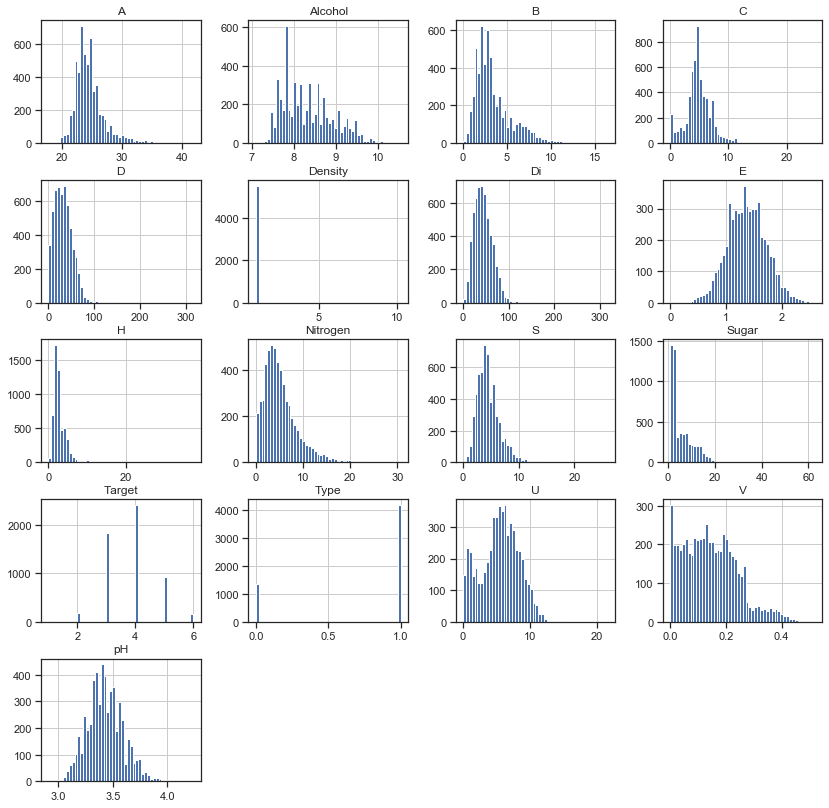

In [137]:
display(data.hist(bins=50, figsize=(14, 14)))

From the graphics above we can see that target classes are not really well-balanced. So let's balance that a bit.I'll duplicate some samples of minority classes(1, 2, 6).

Type        6.007621
Alcohol     3.146441
Nitrogen    1.837499
pH          3.893280
Sugar       3.875789
A           3.860323
B           5.156237
C           3.917890
D           4.935291
Di          4.873313
H           4.504684
S           2.862158
U           5.444656
V           2.682749
dtype: float64


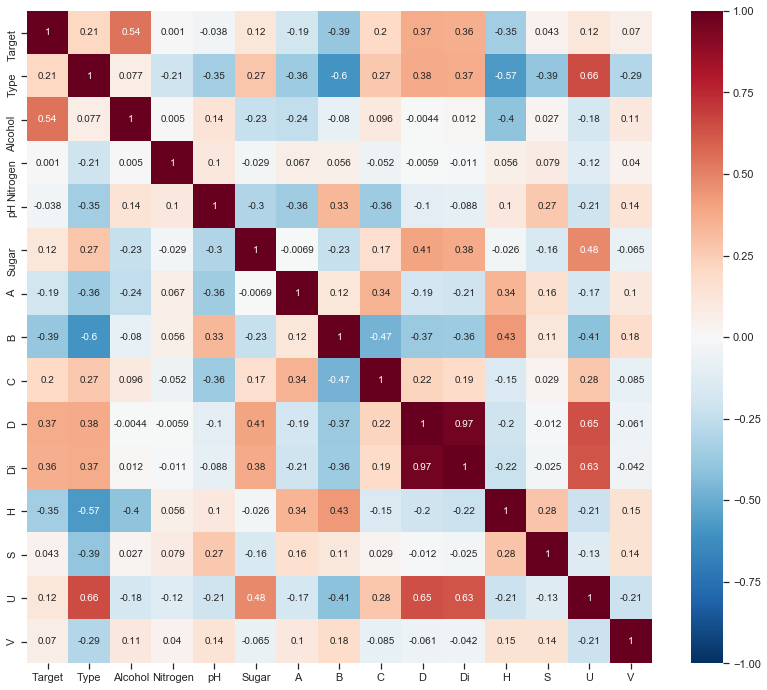

In [145]:
is_needed_class = (data['Target'] == 1) | (data['Target'] == 2) | (data['Target'] == 6)
data_try = data[is_needed_class]
data = data.append([data_try]*5,ignore_index=True)

#let's check some correlation and find out the most necessary and unnecessary ones.
correlation = data.corr()
plt.figure(figsize = (14, 12))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin = -1, cmap = "RdBu_r")
print(correlation[correlation.columns].abs().sum()[1:])

First of all Density turns out to be unnecessary, as its value is 1 everywhere. So I'll drop it.
Moreover, we can see that correlation value of E is quite low. And this way we can get rid of it, as it doesn't influence the result dramatically. Then we can see that 75%-meaning of "Nitrogen", "Sugar", "D", "Di" is much less than their max values as well as several other columns. Consequently we'll have to normalize data in this columns as there are some outliers.

In [139]:
data = data.drop("Density", axis=1)
data = data.drop("E", axis=1)

validation_data = validation_data.drop("Density", axis=1)
validation_data = validation_data.drop("E", axis=1)

Plot below shows us the correlations we were talking above.

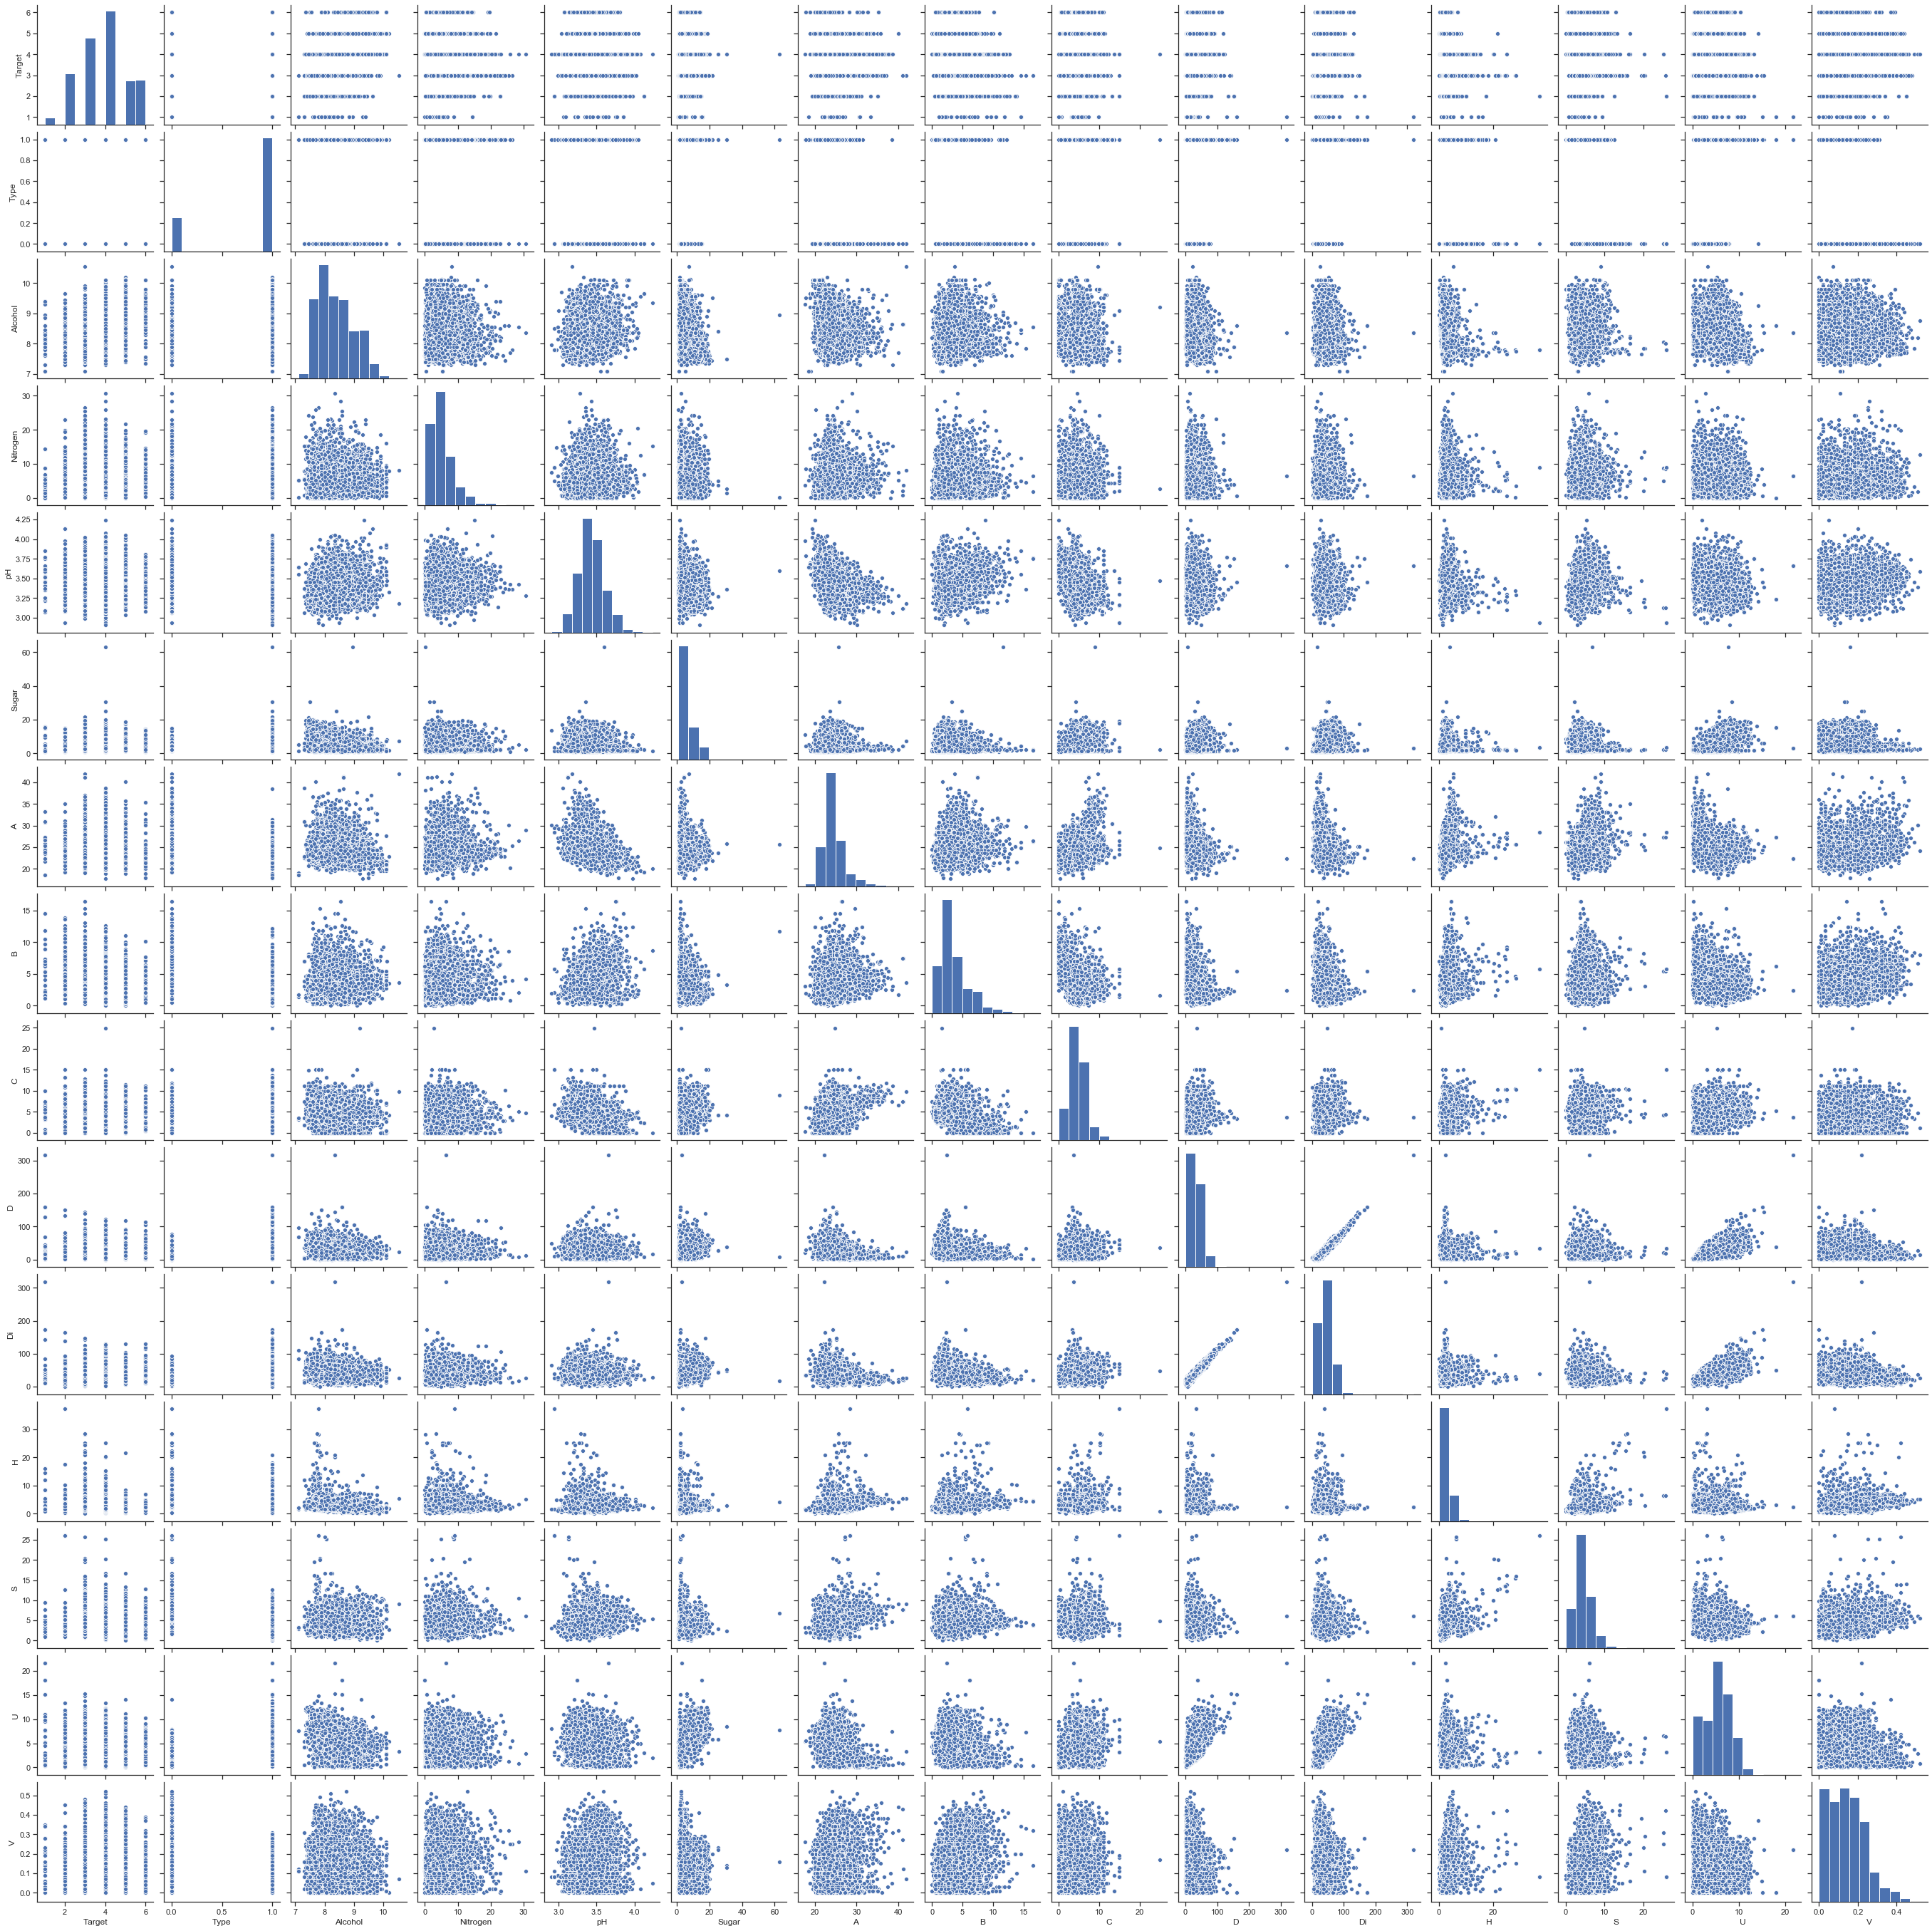

In [131]:
display(sns.pairplot(data))

On the boxplot below we see outliers. We'll get rid of them.

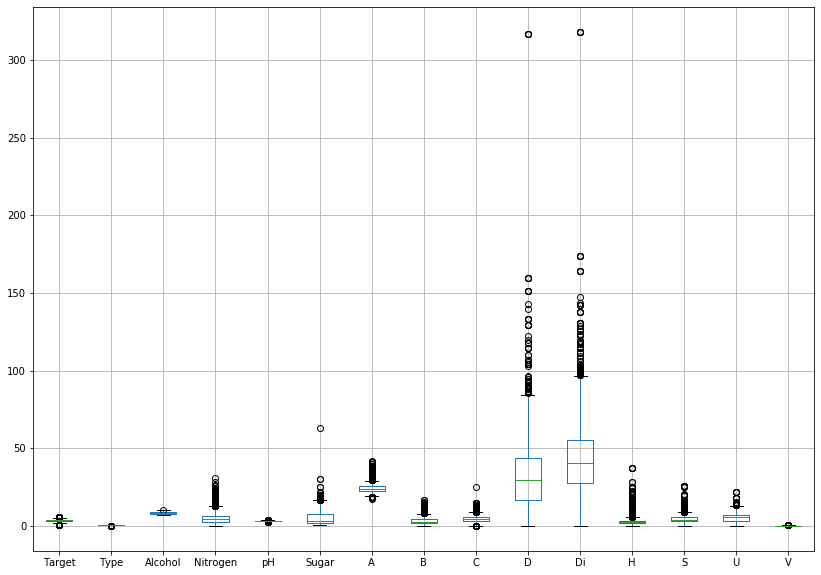

In [116]:
display(data.boxplot(figsize=(14, 10)))

In [140]:
for _ in ['Sugar', 'C', 'D', 'Di', 'H']:
    data_to_delete = data[data[_]>=data[_].quantile(0.996)]
    data = data.drop(data_to_delete.index.values, axis=0).reset_index(drop=True)    

In [146]:
train_batch = data.to_numpy(dtype='float64')[:, 1:]
train_labels = data.iloc[:,:1].to_numpy()
train_labels = train_labels-1

validation_batch = validation_data.to_numpy(dtype='float64')[:, :]

from sklearn.model_selection import train_test_split

def labelList(x):
    temporary = [0, 0, 0, 0, 0, 0]
    temporary[x] = 1
    return temporary

train_batch_for_svm, train_labels_for_svm = train_batch, train_labels 
validation_batch_for_svm = validation_batch

train_labels = np.array([labelList(x[0]) for x in train_labels])

train_batch, test_batch, train_labels, test_labels = train_test_split(
    train_batch[:, :], 
    train_labels, 
    test_size=0.2, 
    shuffle=True)

train_batch_for_svm, test_batch_for_svm, train_labels_for_svm, test_labels_for_svm = train_test_split(
    train_batch_for_svm[:, :], 
    train_labels_for_svm, 
    test_size=0.2, 
    shuffle=True)

My models will be Neural Network with three fully connected layers and SVM.

In [75]:
np.random.seed(0)
random.seed(0)

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = torch.nn.Linear(14, 30)
        #self.conv1_bn = torch.nn.BatchNorm1d(30)
        self.activ1 = torch.nn.Sigmoid()

        self.fc2 = torch.nn.Linear(30, 15)
        self.conv1_bn = torch.nn.BatchNorm1d(15)
        self.activ2 = torch.nn.Sigmoid()
        
        self.fc3 = torch.nn.Linear(15, 6)
        self.activ3 = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x
    
    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
net = Net()

In [147]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(net.parameters(), 
                             lr=1.0e-3)
    
train_batch = torch.FloatTensor(train_batch)
train_labels = torch.LongTensor(train_labels)

test_batch = torch.FloatTensor(train_batch)
test_labels = torch.LongTensor(train_labels)

validation_batch = torch.FloatTensor(validation_batch)

In [154]:
minibatch_size = 50

accuracy_history = []

for epoch in range(5000):
    order = np.random.permutation(len(train_batch))
    for start_index in range(0, len(train_batch), minibatch_size):
        optimizer.zero_grad() 
        minibatch_indexes = order[start_index:start_index+minibatch_size]
        train_minibatch = train_batch[minibatch_indexes]
        train_minitarget = train_labels[minibatch_indexes]
        preds = net(train_minibatch)
        loss_value = loss(preds, torch.max(train_minitarget, 1)[1])
        loss_value.backward()
        optimizer.step()
    if epoch % 100 == 0:
        with torch.no_grad():
            net.eval()   
            test_preds = net.forward(test_batch)
            #print(loss(test_preds, torch.max(test_labels, 1)[1]).item())  
            accuracy = (test_preds.argmax(dim=1) == torch.max(test_labels, 1)[1]).float().mean().data.cpu()
            #print(accuracy)
            accuracy_history.append(accuracy)
        net.train()
        
#plt.plot(accuracy_history)
print(accuracy_history[-1].data*100, "%")

tensor(94.7664) %


In [155]:
from sklearn.svm import SVC
train_labels_for_svm = train_labels_for_svm.reshape(len(train_labels_for_svm),)

test_labels_for_svm = test_labels_for_svm.reshape(len(test_labels_for_svm),)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_batch_for_svm = sc.fit_transform(train_batch_for_svm)
test_batch_for_svm = sc.transform(test_batch_for_svm)

classifier = SVC(kernel = 'rbf', random_state = 0)
trained_model = classifier.fit(train_batch_for_svm, train_labels_for_svm)
trained_model.fit(train_batch_for_svm, train_labels_for_svm)

svm_preds = classifier.predict(test_batch_for_svm)

print(accuracy_score(test_labels_for_svm, trained_model.predict(test_batch_for_svm))*100, "%")

92.68505804518786


Main metric will be the accuracy score. We can see that NN accuracy is approximately 95%. And SVM is 92%. To my mind, the factor that influences accuracy the most is low frequency of definite classes (undersampling). The optimization might be to punish the model for classes with high frequency or to add samples of these classes, for instance  we can just duplicate them. And now I choose NN for Test.csv.

In [157]:
validation_pred = net.forward(validation_batch).argmax(dim=1) + 1
validation_pred = pd.DataFrame(validation_pred.data.numpy())
validation_pred.to_csv("result_.csv")

                                          The Big Conclusion
The highest accuracy I've managed to get with Neural Network is 95%.
The highest accuracy I've managed to get with SVM is 92% on test dataset. The accurasy has been chosen as the main metric. Firstly I've tried to separate targets into three groups: (5, 6)->"good ones", (3, 4)->normal ones and (1, 2)->"bad ones". It improved the result a lot: witn NN i got 93% accuracy on test data. SVM result was 86.5%. In case wine has to be separated into "good quality", "normal quality" and "bad quality" it's possible to identify the quality much better, as I told previously. But if we want to separate data to 6 classes, we need to balance the samples quantity, as I've done.

P.S. The task was quite interesting. I hope you'll provide me with some in the future:) Looking forward to hearing from you soon.